In [13]:
import numpy as np
import pandas as pd

# Load cleaned splits (20 features + target)
train_clean = pd.read_csv("solar_train_clean.csv")
val_clean   = pd.read_csv("solar_val_clean.csv")
test_clean  = pd.read_csv("solar_test_clean.csv")

print(train_clean.shape, val_clean.shape, test_clean.shape)


(61368, 21) (8759, 21) (2925, 21)


In [14]:
TARGET_COL = "Leistung"

# all columns except target are features (20)
feature_cols = [c for c in train_clean.columns if c != TARGET_COL]
n_features = len(feature_cols)
print("Num features:", n_features)
print("Features:", feature_cols)


Num features: 20
Features: ['hour_sin', 'hour_cos', 'Leistung_lag_1', 'Leistung_lag_24', 'Leistung_lag_48', 'Leistung_rolling_mean_24', 'Leistung_rolling_mean_48', 'Leistung_rolling_std_24', 'Leistung_rolling_std_48', 'direct_normal_irradiance_templin_lag_48_rolling_mean_48', 'direct_normal_irradiance_erfurt_lag_48_rolling_mean_48', 'diffuse_radiation_templin_lag_48_rolling_mean_48', 'diffuse_radiation_ingolstadt_lag_48_rolling_mean_24', 'diffuse_radiation_templin_lag_12', 'diffuse_radiation_neumunster_lag_12', 'cloud_cover_guetersloh_lag_24', 'cloud_cover_ingolstadt_lag_48', 'cloud_cover_neumunster_lag_48_rolling_mean_48', 'cloud_cover_erfurt', 'temperature_2m_ingolstadt_lag_48']


In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

TARGET_COL = "Leistung"
feature_cols = [c for c in train_clean.columns if c != TARGET_COL]

scaler = StandardScaler()
scaler.fit(train_clean[feature_cols])   # fit ONLY on train

# create scaled copies
train_scaled = train_clean.copy()
val_scaled   = val_clean.copy()
test_scaled  = test_clean.copy()

train_scaled[feature_cols] = scaler.transform(train_clean[feature_cols])
val_scaled[feature_cols]   = scaler.transform(val_clean[feature_cols])
test_scaled[feature_cols]  = scaler.transform(test_clean[feature_cols])


In [16]:
def create_windows(df, feature_cols, target_col,
                   input_window=24, output_horizon=6):
    """
    df:           pandas DataFrame sorted in time order
    feature_cols: list of feature column names
    target_col:   name of target column ('Leistung')
    input_window: number of past time steps (hours) to use as input
    output_horizon: number of future steps (hours) to predict
    
    Returns:
        X: np.array of shape (num_samples, input_window, n_features)
        y: np.array of shape (num_samples, output_horizon)
    """
    data_features = df[feature_cols].values
    data_target   = df[target_col].values

    n_total = len(df)
    n_features = data_features.shape[1]

    # how many samples we can make
    n_samples = n_total - input_window - output_horizon + 1
    if n_samples <= 0:
        raise ValueError("Not enough rows for given window + horizon.")

    X = np.zeros((n_samples, input_window, n_features), dtype=np.float32)
    y = np.zeros((n_samples, output_horizon), dtype=np.float32)

    for i in range(n_samples):
        # past 24 hours as input
        X[i] = data_features[i : i + input_window]
        # next 6 hours of target as output
        y[i] = data_target[i + input_window : i + input_window + output_horizon]

    return X, y


In [26]:
INPUT_WINDOW   = 24
OUTPUT_HORIZON = 3

X_train, y_train = create_windows(train_scaled, feature_cols, TARGET_COL,
                                  input_window=INPUT_WINDOW,
                                  output_horizon=OUTPUT_HORIZON)

X_val, y_val = create_windows(val_scaled, feature_cols, TARGET_COL,
                              input_window=INPUT_WINDOW,
                              output_horizon=OUTPUT_HORIZON)

X_test, y_test = create_windows(test_scaled, feature_cols, TARGET_COL,
                                input_window=INPUT_WINDOW,
                                output_horizon=OUTPUT_HORIZON)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

INPUT_WINDOW   = X_train.shape[1]   # 24
n_features     = X_train.shape[2]   # 20
OUTPUT_HORIZON = y_train.shape[1]   # 6

l2_reg = 1e-4
drop_rate = 0.3

def residual_block(x, filters, kernel_size, dilation_rate, block_name):
    """
    Residual 1D CNN block with:
        Conv1D (dilated) -> BatchNorm -> ReLU -> Dropout -> Conv1D -> BN
        + shortcut connection
    """
    shortcut = x

    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        kernel_regularizer=regularizers.l2(l2_reg),
        name=f"{block_name}_conv1"
    )(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn1")(x)
    x = layers.ReLU(name=f"{block_name}_relu1")(x)
    x = layers.Dropout(drop_rate, name=f"{block_name}_drop1")(x)

    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        kernel_regularizer=regularizers.l2(l2_reg),
        name=f"{block_name}_conv2"
    )(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn2")(x)

    # match channels in shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(
            filters=filters,
            kernel_size=1,
            padding="same",
            kernel_regularizer=regularizers.l2(l2_reg),
            name=f"{block_name}_shortcut"
        )(shortcut)

    x = layers.Add(name=f"{block_name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{block_name}_relu_out")(x)
    return x

# --------- build model with Functional API ----------
inputs = layers.Input(shape=(INPUT_WINDOW, n_features))

x = inputs

# initial conv to lift dimension a bit
x = layers.Conv1D(
    filters=32,
    kernel_size=3,
    padding="causal",
    activation="relu",
    kernel_regularizer=regularizers.l2(l2_reg),
    name="initial_conv"
)(x)

# stack of residual dilated blocks
dilations = [1, 2, 4, 8]   # you can play with these
for i, d in enumerate(dilations):
    x = residual_block(
        x,
        filters=64,
        kernel_size=3,
        dilation_rate=d,
        block_name=f"resblock_d{d}"
    )

# global pooling over time
x = layers.GlobalAveragePooling1D(name="global_avg_pool")(x)

# fully-connected head
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), name="dense1")(x)
x = layers.Dropout(0.4, name="drop_dense1")(x)

outputs = layers.Dense(OUTPUT_HORIZON, name="forecast_out")(x)

advanced_model = models.Model(inputs=inputs, outputs=outputs, name="TemporalCNN_24to6")

advanced_model.summary()


Model: "TemporalCNN_24to6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_conv        │ (None, 24, 32)    │      1,952 │ input_layer_3[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_conv1   │ (None, 24, 64)    │      6,208 │ initial_conv[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_bn1     │ (None, 24, 64)    │        256 │ resblock_d1_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_relu1   │ (None, 24, 64)    │          0 │ resblock_d1_bn1[… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_drop1   │ (None, 24, 64)    │          0 │ resblock_d1_relu… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_conv2   │ (None, 24, 64)    │     12,352 │ resblock_d1_drop… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_bn2     │ (None, 24, 64)    │        256 │ resblock_d1_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_shortc… │ (None, 24, 64)    │      2,112 │ initial_conv[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_add     │ (None, 24, 64)    │          0 │ resblock_d1_bn2[… │
│ (Add)               │                   │            │ resblock_d1_shor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d1_relu_o… │ (None, 24, 64)    │          0 │ resblock_d1_add[… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_conv1   │ (None, 24, 64)    │     12,352 │ resblock_d1_relu… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_bn1     │ (None, 24, 64)    │        256 │ resblock_d2_conv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_relu1   │ (None, 24, 64)    │          0 │ resblock_d2_bn1[… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_drop1   │ (None, 24, 64)    │          0 │ resblock_d2_relu… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_conv2   │ (None, 24, 64)    │     12,352 │ resblock_d2_drop… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock_d2_bn2     │ (None, 24, 64)    │        256 │ resblock_d2_conv

 Total params: 107,491 (419.89 KB)

 Trainable params: 106,467 (415.89 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [28]:
advanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history_adv = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - loss: 0.7561 - mae: 0.4972 - val_loss: 1.6634 - val_mae: 0.8048 - learning_rate: 0.0010
Epoch 2/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.5976 - mae: 0.4179 - val_loss: 1.6449 - val_mae: 0.7798 - learning_rate: 0.0010
Epoch 3/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.5378 - mae: 0.3899 - val_loss: 1.6253 - val_mae: 0.7577 - learning_rate: 0.0010
Epoch 4/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.4956 - mae: 0.3705 - val_loss: 1.6012 - val_mae: 0.7642 - learning_rate: 0.0010
Epoch 5/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.4646 - mae: 0.3574 - val_loss: 1.6238 - val_mae: 0.7738 - learning_rate: 0.0010
Epoch 6/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.4406 - mae: 0.3467 - val_loss: 1.6237 - val_mae: 0.7629 - learning_rate: 0.0010
Epoch 7/60
480/480 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.4175 - mae: 0.3362 - val_loss: 1.4775 - val_mae: 0.7252 - learning_rate:

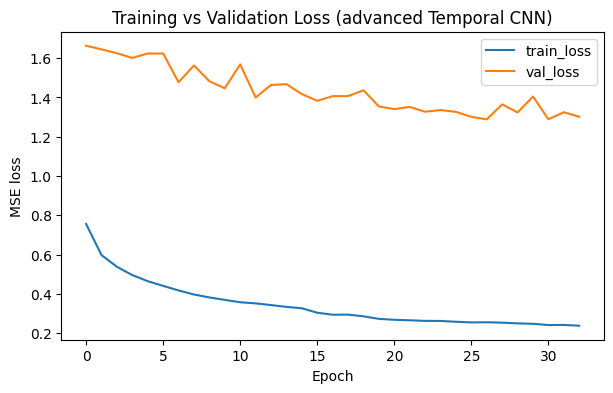

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history_adv.history["loss"], label="train_loss")
plt.plot(history_adv.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Training vs Validation Loss (advanced Temporal CNN)")
plt.show()


In [32]:
test_loss, test_mae = advanced_model.evaluate(X_test, y_test, verbose=0)
print(f"Advanced CNN - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Advanced CNN - Test MSE: 1.6894, Test MAE: 0.7371


In [33]:
y_pred = advanced_model.predict(X_test[:10])

print("Predicted (first sample):", y_pred[0])
print("Actual    (first sample):", y_test[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Predicted (first sample): [0.00477785 0.0020432  0.00458812]
Actual    (first sample): [2.803215e-20 2.803215e-20 2.803215e-20]


In [ ]:
model.save("cnn_24to6_final.keras")
print("Saved CNN model as cnn_24to6_final.keras")
